In [127]:
from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from typing import List, Dict
import numpy as np
import cv2
import torch
from torch import nn
from torchvision.transforms import Compose, Normalize, ToTensor
import timm
import os
import time
from PIL import Image
from efficientnet_pytorch import EfficientNet

# 공식 깃헙에서 가져옴
def preprocess_image(
    img: np.ndarray, mean=[
        0.5, 0.5, 0.5], std=[
            0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)

In [128]:
model = EfficientNet.from_pretrained('efficientnet-b2')

model.load_state_dict(torch.load('weights/2Cycle_TO.pth'), strict=False)
model.to('cuda')

Loaded pretrained weights for efficientnet-b2


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [129]:
layer = model._conv_head
layer

Conv2dStaticSamePadding(
  352, 1408, kernel_size=(1, 1), stride=(1, 1), bias=False
  (static_padding): Identity()
)

In [130]:
rgb_img = cv2.imread('infe_images/plant/to1.jpg')
rgb_img = cv2.resize(rgb_img, (200, 200))
rgb_img = np.float32(rgb_img) / 255 #shape: (200, 200, 3)

input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])


In [131]:

targets = [ClassifierOutputTarget(0)] #ca1 = 0 ca2 = 1 to1 = 0, to2 = 1

# cam 생성 및 처리
cam = AblationCAM(model=model, target_layers=[layer])
cam.batch_size = 1
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

100%|██████████| 1408/1408 [00:30<00:00, 45.86it/s]


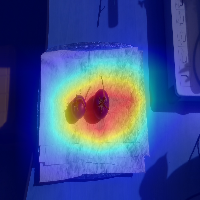

In [132]:
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
display(Image.fromarray(visualization))